In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#default_exp search

In [4]:
#export
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)
import numpy as np
import pandas as pd
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

dev


In [5]:
#export
## temp while api is not aperational
# from food.clipmodel import *
from PIL import Image

In [6]:
#export
foods = read_sql('foods')
# foods = foods.drop(columns = ['clip'])
foods = foods.set_index('id')

In [7]:
# #export
# q = """select  i.food_id,f.description, f.category,f.energy,f.protein,f.carb,f.fat,i.id,i.clip
#                from food.foods_prompted_images i 
#                join food.foods f on (f.id = i.food_id)"""
# foods = pd.read_sql(q,engine).set_index('id')

In [8]:
def mean_vector(g):
    return series2tensor(g).mean(0).reshape(768).detach().clone()

In [9]:
#export
def read_image_from_url(url=None,path=None):
    if url: response = requests.get(url, stream=True)
    if path: pass
    return Image.open(response.raw)



In [10]:
collection_name

'food_text'

In [11]:
#export
def search_image_(url=None,head = 1,env='dev'):
    client = dev_client if env == 'dev' else prod_client
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [12]:
def get_dataset_image(id):
    path = pd.read_sql(f"""select path from food.foods_prompted_images where id = {id}""",engine)['path'].iloc[0]
    return get_image_from_url(f'https://glovo.away.guru/photos_resized/{path}')

In [13]:
def box_area(box):
    return (box[2]-box[0])*(box[3]-box[1])

In [85]:
url = 'https://image.shutterstock.com/z/stock-photo-grilled-salmon-with-green-beans-and-lemon-451391320.jpg'
# t, df = search_image_(url,env = branch)
# cos(t,series2tensor(df['clip']))

In [93]:

thershold = 0.005
params = {'url':url,'thershold':thershold}

image = get_image_from_url(url)
total_size = image.size[0]*image.size[1]

boxes = requests.post('http://127.0.0.1:8185/get_boxes/?',params = params).json()
boxes = [box for box in boxes if box_area(box) >total_size*0.02]
boxes = [box for box in boxes if box_area(box) <total_size*0.7]

photo_id = url.split('/')[-1]
urls = []
for id, box in enumerate(boxes):
    urls.append(f'https://glovo.away.guru/fragment_reference_images/{photo_id}_{id}.jpg')
    

df = pd.DataFrame()
for u in urls:
    df = df.append(search_image_(u,head = 1,env=branch)[1])
df = df.reset_index(drop = True)
df = df[df['score']>0.2]
df = df.drop_duplicates('description')


draw = ImageDraw.Draw(image)
for i, box in  zip(df.index,boxes):
    draw.rectangle((box))
    draw.text((box[0],box[1]), df.loc[i,'description'], fill="black")

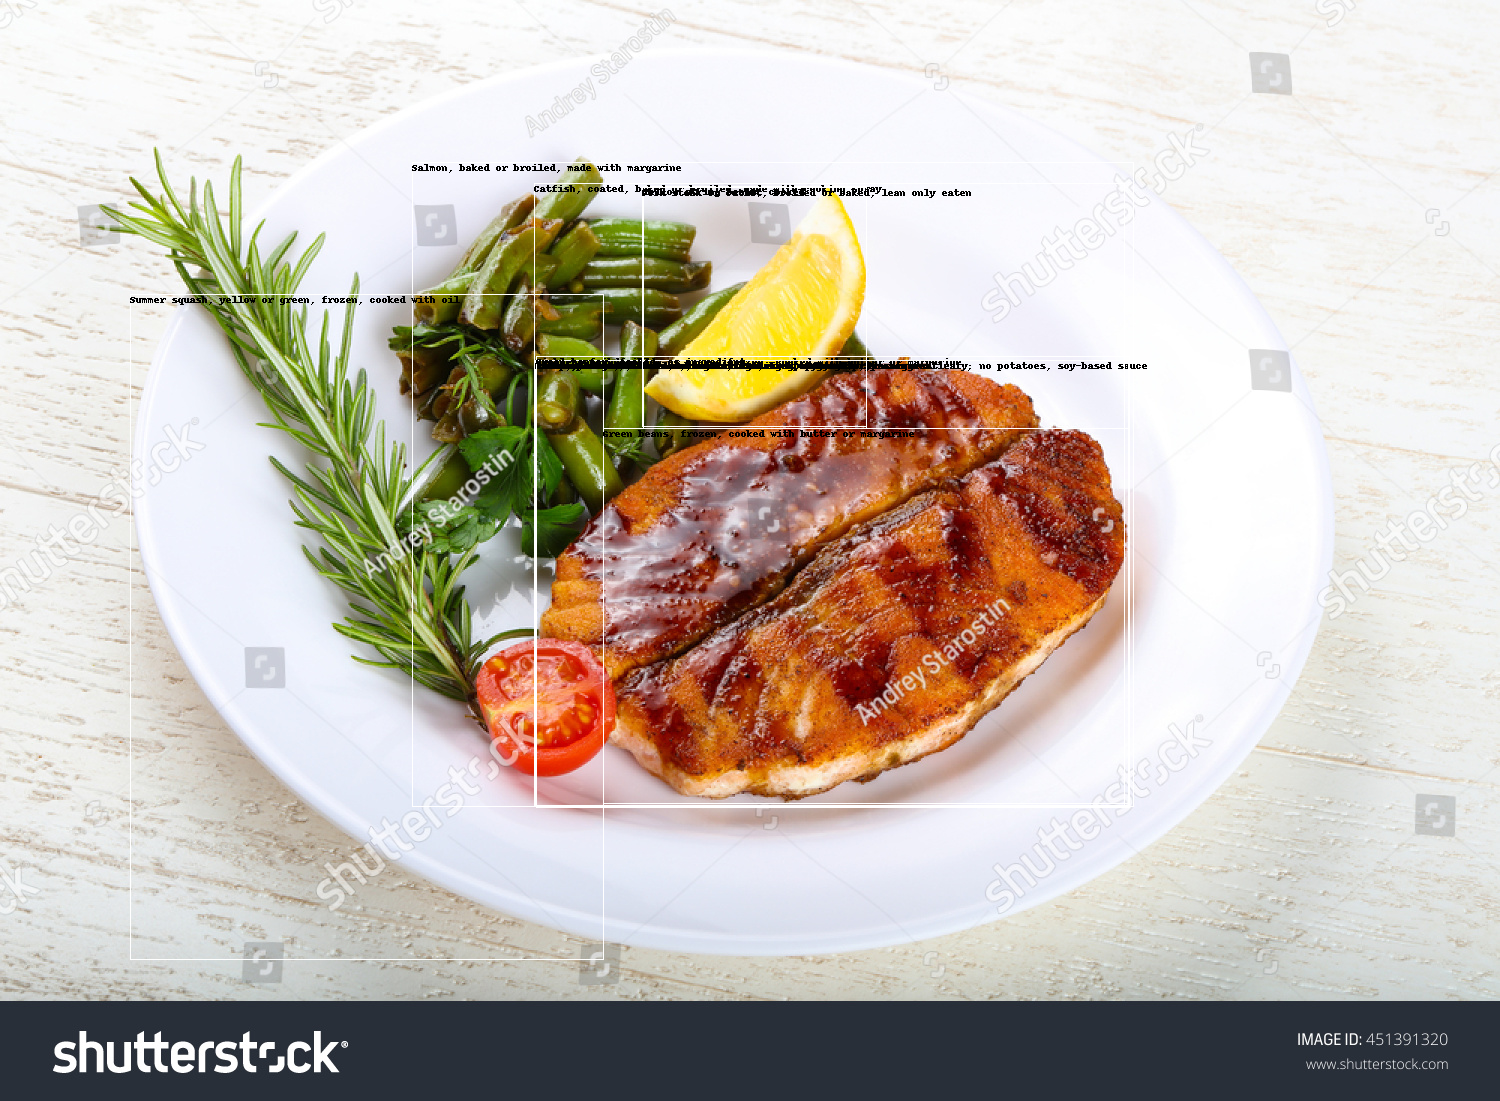

In [94]:
image

In [95]:
df

id                                        description  \
0   1103454                        Yellow string beans, cooked   
1   1098971  Salmon, coated, baked or broiled, made with co...   
2   1098966  Salmon, baked or broiled, made with cooking spray   
3   1100088  Fish in lemon-butter sauce with starch item, v...   
16  1099205                    Ham or pork with barbecue sauce   
18  1103069                                Green banana, fried   
24  1099075    Tilapia, coated, fried, made with cooking spray   
28  1103687                                     Pickles, fried   
29  1102715  Fruit salad, fresh or raw, including citrus fr...   
30  1098964      Salmon, baked or broiled, made with margarine   
33  1103586  Summer squash, yellow or green, frozen, cooked...   
34  1103587  Summer squash, yellow or green, frozen, cooked...   
39  1102594                                         Lemon, raw   
40  1103446  Green beans, frozen, cooked with butter or mar...   
45  1099737  Fish and vegetables including carrots, broccol...   
49  1101970  Pizza, cheese, from restaurant or fast food, N...   
55  1104580                Green pepper, cooked, as ingredient   
56  1098792  Catfish, coated, baked or broiled, made with c...   
57  1098268  Pork steak or cutlet, broiled or baked, lean o...   

                                 category  energy  protein   carb    fat  \
0                            String beans    50.0     1.45   6.25   2.70   
1                                    Fish   197.0    22.36  13.14   5.35   
2                                    Fish   164.0    25.72   0.20   5.92   
3                    Seafood mixed dishes   100.0     5.46  10.98   3.76   
16                      Meat mixed dishes   205.0    21.04  12.69   7.19   
18               Other starchy vegetables   144.0     1.26  30.87   3.24   
24                                   Fish   178.0    23.63  11.64   3.91   
28                       Fried vegetables   210.0     3.32  20.47  12.79   
29          Other fruits and fruit salads    52.0     0.76  13.26   0.21   
30                                   Fish   177.0    25.07   0.13   7.84   
33      Other vegetables and combinations    46.0     1.18   4.40   3.06   
34      Other vegetables and combinations    40.0     1.19   4.42   2.33   
39                          Citrus fruits    29.0     1.10   9.32   0.30   
40                           String beans    46.0     1.46   6.26   2.33   
45  Stir-fry and soy-based sauce mixtures   103.0     7.83   4.78   6.00   
49                                  Pizza   266.0    11.39  33.33   9.69   
55        Not included in a food category    22.0     0.92   4.99   0.18   
56                                   Fish   189.0    17.23  13.14   6.85   
57                                   Pork   171.0    24.61   0.07   7.42   

                                                 clip     score  
0   [0.058182165, 0.010359109, -0.0072919084, -0.0...  0.286354  
1   [-0.01526797, 0.025937725, -0.007608482, 0.002...  0.270466  
2   [-0.014153425, 0.020180795, -0.0042874473, -0....  0.277331  
3   [0.0070917155, 0.0097165, -0.0034807927, 0.028...  0.276282  
16  [0.021320673, 0.052117083, 0.018656045, -0.037...  0.272776  
18  [0.04995233, 0.007721414, -0.021592837, 0.0053...  0.239332  
24  [-0.0077374997, -0.016264664, -0.026152149, 0....  0.272151  
28  [0.019606091, 0.00063159486, 0.007517654, -0.0...  0.261109  
29  [0.027070515, 0.04700574, 0.0028922444, 0.0152...  0.262211  
30  [-0.009479306, 0.02625067, -0.0033650144, -0.0...  0.268715  
33  [0.013290607, 0.030112734, 0.02079095, -0.0120...  0.250132  
34  [0.036732517, 0.02997881, 0.023087543, -0.0155...  0.261939  
39  [0.033576965, 0.017405322, 0.019060813, -0.025...  0.264483  
40  [0.038510025, 0.036403265, 0.0048620896, 0.021...  0.306473  
45  [0.033912405, 0.03472273, -0.0123392595, 0.012...  0.272899  
49  [0.009587851, 0.02125338, 0.03126051, -0.01058...  0.265778  
55  [0.036521234, 0.029670924, 0.0054768524, 

In [11]:
#export
drop_vector =      lambda clip, i: torch.cat([clip[0:i], clip[i+1:]])

def multiply_vector(clip,i,n=1):
    duplicated = torch.cat([clip[i].reshape(1,768) for _ in range(n)])
    return torch.cat([clip, duplicated.reshape(n,768)])

In [12]:
#export
def multiple_foods(url,env='dev'):

    image_clip,selected = search_image_(url,head=100,env=env)
    # selected=selected[selected['category'].isin(selected_categories)]
    selected=selected.reset_index(drop=True)
    clip = series2tensor(selected['clip'])
    initscore = float(cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768)).detach().clone())
    startscore = initscore-0.0000001
    n=0

    while startscore !=initscore:
        startscore = initscore
        
        selected = selected.reset_index(drop=True)
        for i in reversed(selected.index):
            clip = series2tensor(selected['clip'])
            dropped = drop_vector(clip,i)
            testscore = float(cos(image_clip.reshape(1,768), dropped.mean(0).reshape(1,768)).detach().clone())

            if testscore > initscore-0.0001: 
                r = selected.loc[i,'description']
                selected = selected.drop(i)
                initscore = testscore

            else:
                extra = multiply_vector(clip,i,1)
                testscore = float(cos(image_clip.reshape(1,768), extra.mean(0).reshape(1,768)).detach().clone())
                if testscore > initscore: 
                    selected = selected.append(selected.loc[i])
                    initscore = testscore

            n+=1
            if n ==15:break

        print(initscore)
    count = selected.groupby('description')['clip'].count().sort_index()
    r = selected.drop_duplicates('description').set_index("description").sort_index()
    r['count'] = count
    r = r.sort_values('count',ascending = False)
    r['share'] = r['count'].cumsum()/r['count'].sum()

    description = '. '.join(r[r['share']<0.9].index.unique().tolist())


    return r.drop(columns = ['clip']), description, selected,initscore
    

In [13]:
#export
def search_image(url,env='dev'):
    r, desc, sel,score = multiple_foods(url,env=env)
    df = sel[['energy','protein','carb','fat','score']].mean().to_frame().T
    df['score'] =score
    df['description'] = desc
    return df


In [14]:
url = 'https://image.shutterstock.com/z/stock-photo-fresh-tasty-burger-isolated-on-white-background-705104968.jpg'

In [15]:
r, desc, sel,score = multiple_foods(url,env='prod')

/tmp/ipykernel_178094/3265430290.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/torch/csrc/utils/tensor_new.cpp:201.)
  series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])


0.9241994199612956
0.9489574442447687
0.9554999711028429
0.9556667475742928
0.9557574340674231
0.955895068238691
0.955895068238691


In [16]:
desc

'Egg, cheese and sausage on bagel. Hamburger, from fast food, 1 large patty. Soft drink, root beer, diet. Egg, cheese, ham, and bacon on bun. Hamburger (McDonalds). Cheeseburger, from fast food, 1 large patty'

In [17]:
r

id  food_id  \
description                                                         
Egg, cheese and sausage on bagel                   43648  1100331   
Hamburger, from fast food, 1 large patty           34101  1099802   
Soft drink, root beer, diet                       101947  1104328   
Egg, cheese, ham, and bacon on bun                 43328  1100315   
Hamburger (McDonalds)                              33987  1099796   
Cheeseburger, from fast food, 1 large patty        33686  1099781   
Double hamburger, on white bun, 2 medium patties   34266  1099810   
Double hamburger, on white bun, 2 small patties    34232  1099808   
Hamburger slider                                   34021  1099798   

                                                                                category  \
description                                                                                
Egg, cheese and sausage on bagel                  Egg/breakfast sandwiches (single code)   
Hamburger, from fast food, 1 large patty                           Burgers (single code)   
Soft drink, root beer, diet                                             Diet soft drinks   
Egg, cheese, ham, and bacon on bun                Egg/breakfast sandwiches (single code)   
Hamburger (McDonalds)                                              Burgers (single code)   
Cheeseburger, from fast food, 1 large patty                        Burgers (single code)   
Double hamburger, on white bun, 2 medium patties                   Burgers (single code)   
Double hamburger, on white bun, 2 small patties                    Burgers (single code)   
Hamburger slider                                                   Burgers (single code)   

                                                  energy  protein   carb  \
description                                                                
Egg, cheese and sausage on bagel                   295.0    12.98  22.64   
Hamburger, from fast food, 1 large patty           289.0    18.43  17.12   
Soft drink, root beer, diet                          0.0     0.10   0.00   
Egg, cheese, ham, and bacon on bun                 250.0    14.48  17.25   
Hamburger (McDonalds)                              263.0    13.30  29.57   
Cheeseburger, from fast food, 1 large patty        300.0    18.79  15.15   
Double hamburger, on white bun, 2 medium patties   290.0    19.51  13.02   
Double hamburger, on white bun, 2 small patties    289.0    19.18  14.26   
Hamburger slider                                   288.0    17.76  19.71   

                                                    fat     score  count  \
description                                                                
Egg, cheese and sausage on bagel                  16.97  0.842053      4   
Hamburger, from fast food, 1 large patty          15.63  0.889186      4   
Soft drink, root beer, diet                        0.00  0.862068      4   
Egg, cheese, ham, and bacon on bun                13.23  0.840220      2   
Hamburger (McDonalds)                             10.18  0.865655      2   
Cheeseburger, from fast food, 1 large patty       17.68  0.892620      1   
Double hamburger, on white bun, 2 medium patties  17.09  0.889645      1   
Double hamburger, on white bun, 2 small patties   16.65  0.889645      1   
Hamburger slider                                  14.72  0.872722      1   

                                                  share  
description                                              
Egg, cheese and sausage on bagel                   0.20  
Hamburger, from fast food, 1 large patty           0.40  
Soft drink, root beer, diet                        0.60  
Egg, cheese, ham, and bacon on bun                 0.70  
Hamburger (McDonalds)                              0.80  
Cheeseburger, from fast food, 1 large patty        0.85  
Double hamburger, on white bun, 2 medium patties   0.90  
Double hamburger, on white bun, 2 small patties    0.95  
Hamburger slider           

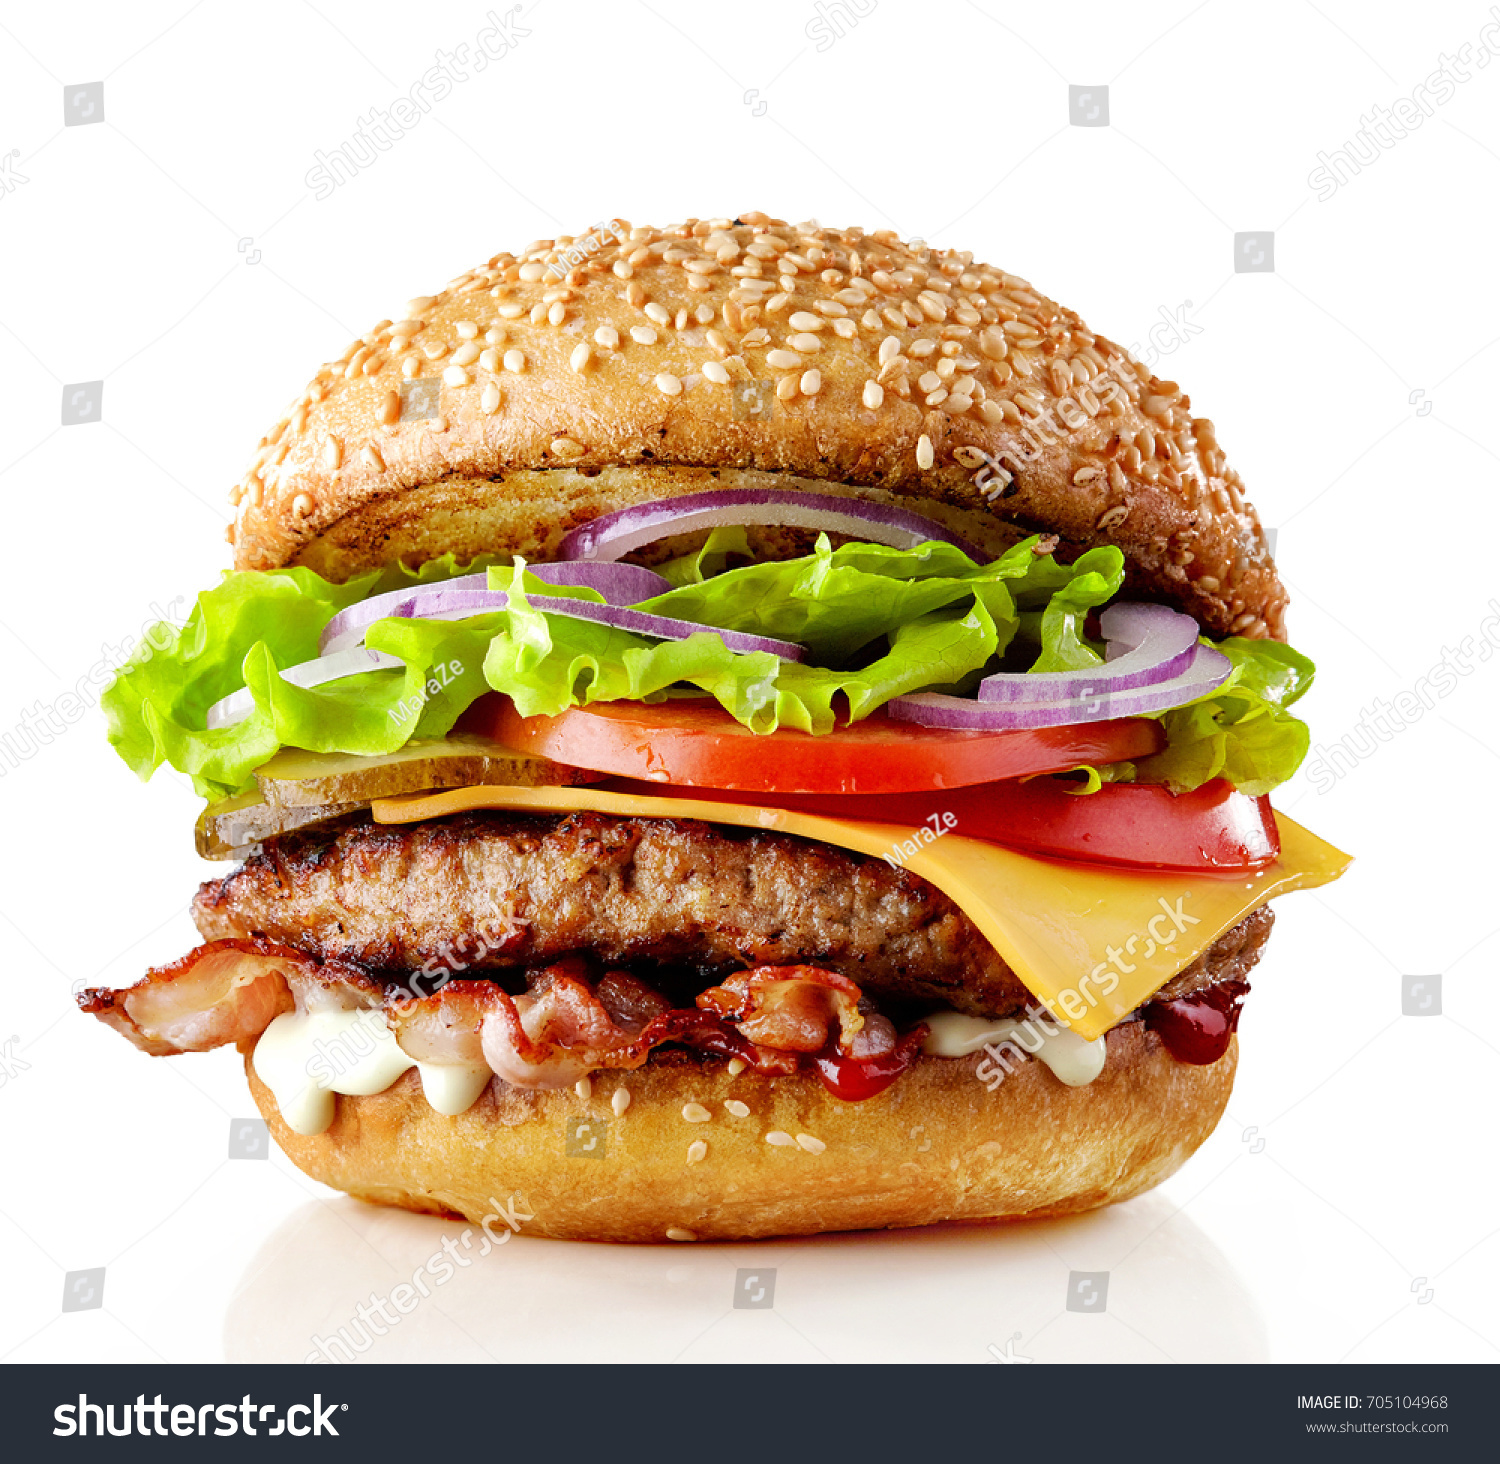

In [18]:
get_image_from_url(url)

In [19]:
search_image(url,'prod')

0.9241994199612956
0.9489574442447687
0.9554999711028429
0.9556667475742928
0.9557574340674231
0.955895068238691
0.955895068238691


energy  protein    carb     fat     score  \
0  226.45   12.842  15.741  12.168  0.955895   

                                         description  
0  Egg, cheese and sausage on bagel. Hamburger, f...

In [20]:
!nbdev_build_lib

Converted 00_clipmodel.ipynb.
Converted 00_custom_pandas.ipynb.
Converted 00_paths.ipynb.
Converted 00_progress_check.ipynb.
Converted 00_psql.ipynb.
Converted 00_qdrant.ipynb.
Converted 00_tools.ipynb.
Converted 01_search.ipynb.
Converted inference.ipynb.
Converted stats.ipynb.
